# Explorando o Datset do desafio do Titanic (em Python)

## Introdução

Essa é a minha primeira tentativa de aplicação de ML com a ajuda do meu mentor de Data Science.Como base para este trabalho eu peguei a base de dados clássica do Titanic no Kaggles e realizei a análise em Python como uma maneira de treinar meus conhecimentos na linguagem e na prática de análise de dados. Também peguei diversas referências na internet de pessoas que já haviam feito esse desafio.
Meu script foi divido em 3 partes:

- Background
- Exploração e análise dos dados
- Análise e imputação de valores faltantes e outliers 
- Feature engineering
- Construção dos modelos de ML
- Prediction

## Background

## O desafio

O Titanic é um dos naufrágios mais famosos da história.
Em 1912, durante sua viagem inaugural, o RMS Titanic afundou após colidir com um iceberg. Infelizmente, não havia botes salva-vidas suficientes para todos a bordo, resultando na morte de diversos passageiros e tripulantes.
Embora houvesse algum elemento de sorte envolvido na sobrevivência, parece que alguns grupos de pessoas tinham uma maior probabilidade de sobreviver do que outros.
Neste desafio, o objetivo é construir um modelo preditivo que responda a que tipo de pessoa tem mais probabilidade de sobreviver, a partir de diversar características dos passageiros (por exemplo, nome, idade, sexo, classe socioeconômica, etc.).

### Importando as bibliotecas

In [63]:
import warnings

warnings.filterwarnings('ignore')

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Carregando os dados

In [65]:
titanic_treinamento = pd.read_csv('/content/drive/MyDrive/train.csv')
titanic_teste = pd.read_csv('/content/drive/MyDrive/test.csv')

### Sumário dos dados:
- passengerid = ID do passageiro do navio (chave primária)
- survived = Se sobreviveu ao naufrágio(1) ou não(0)
- pclass = Classe socieconômica do passageiro (1, 2 ou 3)
- name = Nome do passageiro
- sex = Gênero do passageiro, sendo masculino ou feminino.
- age = Idade do passageiro
- sibsp = Número de irmãos a bordo.
- parch = Número de parentes a bordo.
- ticket = Código do ticket.
- fare = Valor da passagem.
- cabin = Código de identificação da Cabine.
- embarked = Local onde o passageiro embarcou no navio (S=Southampton, C=Cherbourg, Q=Queenstown.

Reorganizando as colunas para o meu 'target' ficar na ponta (apenas uma questão de organização pessoal)

In [66]:
titanic_treinamento = titanic_treinamento.reindex(columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'])
titanic_teste = titanic_teste.reindex(columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])

## Exploração e análise dos dados

Visualizando a aparência da base de dados

Visual das primeiras linhas.

In [67]:
titanic_treinamento.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [68]:
titanic_teste.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Visual das últimas linhas.

In [69]:
titanic_treinamento.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1
890,891,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0


In [70]:
titanic_teste.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


A partir das tabelas acima já podemos verificar que teremos que realizar algumas conversões de variáveis para numéricas para que os algoritmos possam processá-las. Além disso, podemos ver que as features tem ordem de grandeza muito diferente entre si, portanto teremos que normalizá-las para não gerar viés no nosso modelo.

In [71]:
titanic_treinamento.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


Acima podemos verificar, pela média da variável target 'Survived', que em torno de 38% das pessoas sobreviveu no Titanic. Também já conseguimos ver que a feature 'Age' contém alguns valores faltantes, pois a sua contagem está abaixo do número total de registros, além disso podemos verificar que nenhuma das features conta com 'erros' de registro pois pelo máximo e mínimo de cada variável não temos nenhum valor que não faz sentido como idade negativa ou taxa negativa...
Entretanto essa função nos mostra as informações apenas das variáveis numéricas.

In [72]:
titanic_treinamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Com a função acima conseguimos algumas informações sobre todas as variáveis:numéricas e categóricas. E a partir disso verificamos que a base de treinamento tem 891 registros e 11 features + a variavel target (survived). Temos 5 features tipo integers, 5 objects e 2 floats. Também é possível verificar que temos alguns dados faltantes que serão tratados mais adiante.

In [73]:
titanic_teste.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [74]:
titanic_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Já na base de teste temos menos problemas com dados faltantes, mas igual iremos tratar mais adiante.

Afim de conhecer melhor os dados gerei diversos gráficos que já conseguem me dar uma ideia maior do que esperar na previsão do algoritmo.

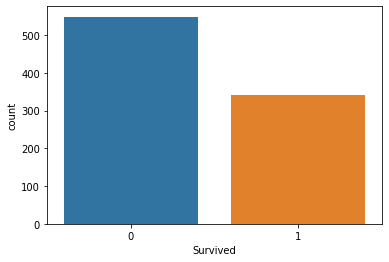

In [75]:
sns.countplot(titanic_treinamento['Survived'], label="Count");

A partir dessa simples contagem da nossa variável target já conseguimos perceber que a maioria não sobreviveu.

In [76]:
tabela = pd.pivot_table(data=titanic_treinamento, values='PassengerId', index='Sex', columns='Survived', aggfunc='count')
print(tabela)

Survived    0    1
Sex               
female     81  233
male      468  109


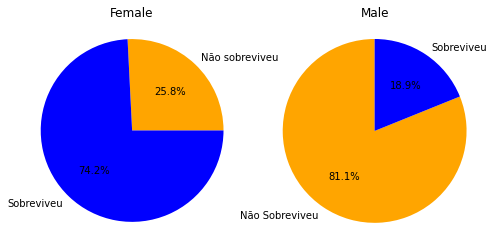

In [77]:
pie_fem=tabela.loc['female']
pie_masc=tabela.loc['male']

fig, eixos=plt.subplots(nrows=1, ncols=2, figsize=(8,4))
pie_1=eixos[0].pie(pie_fem, labels=['Não sobreviveu', 'Sobreviveu'],
                  autopct='%1.1f%%', colors=['orange', 'blue'])
eixos[0].set_title('Female')
eixos[0].axis('equal')

pie_2 = eixos[1].pie(pie_masc, labels=['Não Sobreviveu','Sobreviveu'], 
                    autopct='%1.1f%%', startangle=90, colors=['orange', 'blue'])
eixos[1].set_title('Male')
plt.axis('equal')
plt.show()

Ao cruzarmos a variável 'sex' com a 'survived' podemos perceber que maior parte das mulheres sobreviveu. O que vai de acordo com o que vimos no filme, pois na hora do resgate mulheres e crianças foram priorizadas.

In [78]:
titanic_treinamento[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).count().sort_values(by='Survived', ascending=False)

,Pclass,Survived
2,3,491
0,1,216
1,2,184


Se fizermos uma contagem simples da nossa variável 'Pclass' podemos ficar com a ideia erronea de que mais pessoas da 3ª classe sobreviveram. Por isso, assim como fiz com 'sex' vou cruzar essa variável com a nossa target.

In [79]:
tabela2 = pd.pivot_table(data=titanic_treinamento, values='PassengerId', index='Pclass', columns='Survived', aggfunc='count')

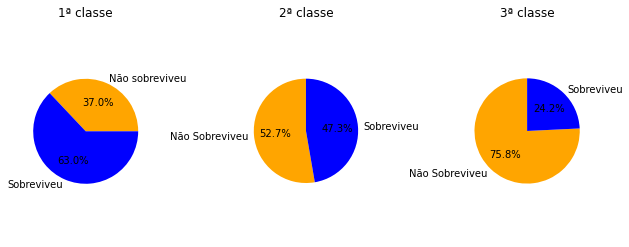

In [80]:
pie_first=tabela2.loc[1]
pie_second=tabela2.loc[2]
pie_third=tabela2.loc[3]

fig, eixos=plt.subplots(nrows=1, ncols=3, figsize=(10,4))
plt.subplots_adjust(wspace = 0.9)

pie_1=eixos[0].pie(pie_first, labels=['Não sobreviveu', 'Sobreviveu'],
                  autopct='%1.1f%%', colors=['orange', 'blue'])
eixos[0].set_title('1ª classe')
eixos[0].axis('equal')

pie_2 = eixos[1].pie(pie_second, labels=['Não Sobreviveu','Sobreviveu'], 
                    autopct='%1.1f%%', startangle=90, colors=['orange', 'blue'])
eixos[1].set_title('2ª classe')
eixos[1].axis('equal')

pie_3 = eixos[2].pie(pie_third, labels=['Não Sobreviveu','Sobreviveu'], 
                    autopct='%1.1f%%', startangle=90, colors=['orange', 'blue'])
eixos[2].set_title('3ª classe')
plt.axis('equal')
plt.show()

Como podemos ver a partir dessa perspectiva concluimos que na verdade, ainda que em valores brutos tenha sobrevivido mais pessoas da 3ª classe, apenas uma pequena parcela da 3ª classe sobreviveu. Como esperado, e de novo de acordo com o filme, os passageiros que estavam nas classes mais abastadas (1ª e 2ª) foram priorizados nos resgates.

No caso de variáveis numéricas não faz muito sentido fazer uma contagem como nos outros casos. Então para ver a distribuição da idade dos passageiros gerei um histograma.

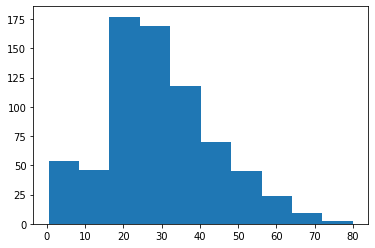

In [81]:
plt.hist(x = titanic_treinamento['Age']);

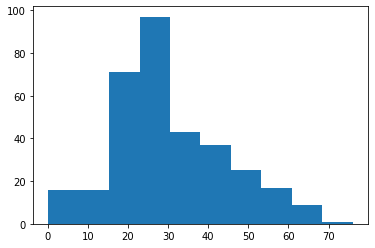

In [82]:
plt.hist(x = titanic_teste['Age']);

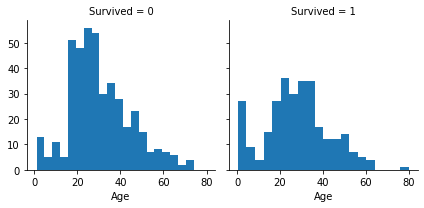

In [83]:
sns.FacetGrid(titanic_treinamento, col='Survived').map(plt.hist, 'Age', bins=20);

Fazendo um cruzamento com a variável target podemos verificar que os passageiros tem em média entre 20 e 40 anos e que passageiros mais jovens tendem a sobreviver.

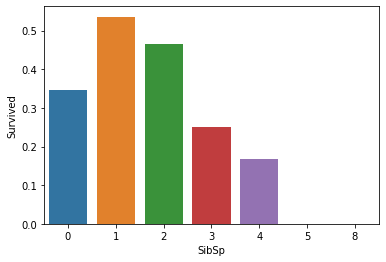

In [84]:
sns.barplot(x='SibSp', y='Survived', ci=None, data=titanic_treinamento);

Analisando a variável 'SibSp' verificamos que pessoas que viajaram com 1 irmão sobreviveram mais do que o resto.

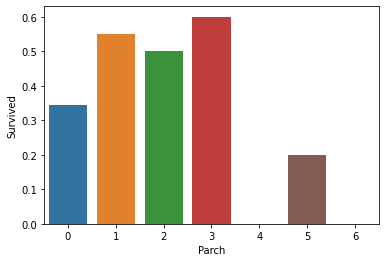

In [85]:
sns.barplot(x='Parch', y='Survived',ci=None, data=titanic_treinamento);

Analisando a variável 'Parch' demonstra que pessoas viajando com pais ou crianças tinham uma probabilidade maior de sobreviver do que aqueles que viajaram sozinhos.

In [86]:
titanic_treinamento[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).count().sort_values(by='Survived', ascending=False)

,Embarked,Survived
2,S,644
0,C,168
1,Q,77


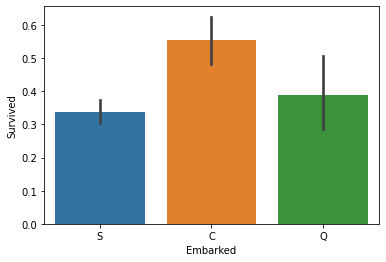

In [87]:
sns.barplot(x='Embarked', y='Survived', data=titanic_treinamento);

Os passageiros embarcados no Porto de Cherbourg têm maior probabilidade de sobreviver. Ainda que em números brutos tenha sobrevivido mais pessoas do Porto de Southampton.

## Análise e imputação de valores faltantes e outliers 

Agora vamos verificar e tratar os dados nulos das nossas bases.

In [88]:
titanic_treinamento.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

Como podemos ver temos muitos valores nulos em 'Age' e 'Cabin', principalmente. Como a base não é exatamente "gigante" não é interessante para nós sair simplesmente deletando todas essas linhas.

Então antes de tratar esse valores nulos sem deletá-los vou separar em uma base separada para analisar se existe algum tipo de padrão ou explicação para que esses valores estejam faltando.

In [89]:
#fazer uma analise separada das cabines nulas
titanic_cabinnull = titanic_treinamento.loc[pd.isnull(titanic_treinamento['Cabin'])]
titanic_cabinnull

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,0
885,886,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0


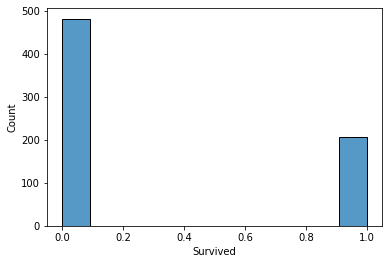

In [90]:
sns.histplot(titanic_cabinnull, x='Survived');

A maioria dos passageiros que tem sua informação de cabine faltando não sobreviveu. No entanto, na nossa base geral isso já era a maioria então isso não nos dá nenhuma dica sobre o moitvo para estarem falatando.

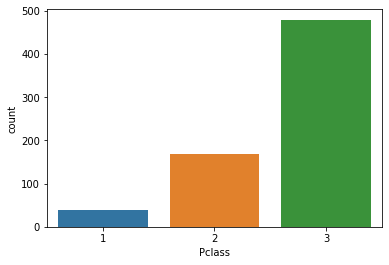

In [91]:
sns.countplot(titanic_cabinnull['Pclass'], label="Count");

Agora esse gráfico da variável 'Pclass' já nos dá uma ideia, por que maior parte dos registro de cabine faltantes é da 3ª classe e isso pode se dever pelo fato de ser a classe menos abastada e muito provavelmente essas pessoas nem tinham cabine como no caso da 1ª e 2ª classe.

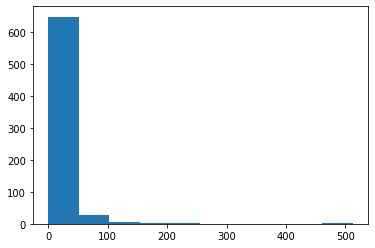

In [92]:
plt.hist(x = titanic_cabinnull['Fare']);

Analisando pela taxa paga nas passagens vai de acordo com a nossa hipótese ou seja, 3ª classe, pessoas menos abastadas e taxas mais baratas.

Certo. Então vamos começar a tratar nossos nulos, visando perder a menor quantidade de dados possível.

In [93]:
titanic_teste.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [94]:
titanic_treinamento.loc[pd.isnull(titanic_treinamento['Age'])]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
17,18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1
19,20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1
26,27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,1
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,0
863,864,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,0
868,869,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,0
878,879,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,0


Como a variável 'Age' é uma variável numérica um dos métodos que podemos utilizar aqui é substituindo os valores faltantes pela média, assim não criamos nenhum viés diferente do original na nossa base.

In [95]:
titanic_treinamento['Age'].fillna(titanic_treinamento['Age'].mean(), inplace = True)
titanic_teste['Age'].fillna(titanic_teste['Age'].mean(), inplace = True)

No caso da variável 'Fare' da base de teste era apenas um linha com o valor faltante então nesse caso eu simplesmente deletei o registro.

In [96]:
titanic_teste['Fare'].fillna(titanic_teste['Fare'].mean(), inplace = True)

In [97]:
titanic_treinamento.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [98]:
titanic_teste.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

Também afim de simplificar minha análise resolvi desconsiderar as variável 'Ticket' pois acredito que não existe nenhuma informação importante a ser retirada do código do ticket.

In [99]:
titanic_treinamento2 = titanic_treinamento.drop('Ticket', axis = 1)
titanic_teste2 = titanic_teste.drop('Ticket', axis = 1)

In [100]:
titanic_treinamento2.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [101]:
titanic_teste2.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          327
Embarked         0
dtype: int64

A mesma coisa que fiz com 'Fare' da base de teste vou fazer com 'Embarked' da base de treinamento.

In [102]:
titanic_treinamento3 = titanic_treinamento2.dropna(subset=['Embarked'])
titanic_teste3 = titanic_teste2 #apenas para deixar os dois nomes parecidos

In [103]:
titanic_treinamento3.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         0
Survived         0
dtype: int64

In [104]:
titanic_teste3.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          327
Embarked         0
dtype: int64

A princípio como a informação de cabine tinhas muitos valores faltantes eu ia simplesmente deletar, porém vendo alguns exemplos na internet descobri que poderia tirar algumas informações interessantes dessa variável.
Basicamente o que ocorre é que a primeira letra do código de cabine indica a posição no Titanic dessas cabines. Então como a primeira classe tinha as cabines A, B ou C, a segunda em D ou E e a terceira classe era principalmente na F ou G, essa informação pode ser muito importante na hora da previsão.

Basicamente vou tratar essa variável em duas etapas, primeiro vou criar uma nova categoria para os valores faltantes e mais adiante vou extrair do código das cabines apenas as letras.

In [105]:
titanic_treinamento3['Cabin'] = titanic_treinamento3['Cabin'].fillna("U0")
titanic_teste3['Cabin'] = titanic_teste3['Cabin'].fillna("U0")

In [106]:
titanic_treinamento3.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Survived       0
dtype: int64

In [107]:
titanic_teste3.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Ótimo agora que já tratamos todos os valores faltantes podemos seguir com algum 'feature engineering'.

## Feature engineering

Vamos começar deletando a a coluna de ID por que ela só serve como identificador de cada passageiro listado na base.

In [108]:
titanic_treinamento3 = titanic_treinamento3.drop('PassengerId', axis = 1)
titanic_teste3 = titanic_teste3.drop('PassengerId', axis = 1)

A variável nome do passageiro a princípio não nos trás muita informação, entretanto, além do nome da pessoa a variável vem com o título da pessoa que indica o status social, sendo assim vou extrair apenas o título dos passageiros.

In [109]:
titanic_treinamento3['Title'] = titanic_treinamento3['Name'].str.extract('(\w*\.)', expand=False)
titanic_teste3['Title'] = titanic_teste3['Name'].str.extract('(\w*\.)', expand=False)

Assim podemos desconsiderar a variável 'Name' e ficar apenas com a 'Title'.

In [110]:
titanic_treinamento4 = titanic_treinamento3.drop('Name', axis = 1)
titanic_teste4 = titanic_teste3.drop('Name', axis = 1)

In [111]:
titanic_treinamento4 = titanic_treinamento4.reindex(columns = ['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Survived'])
titanic_teste4 = titanic_teste4.reindex(columns = ['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Survived'])

Em uma contagem rápida da frequência de cada título verificamos que tem muitos títulos.

In [112]:
titanic_treinamento4.groupby('Title')['Title'].count()

Title
Capt.          1
Col.           2
Countess.      1
Don.           1
Dr.            7
Jonkheer.      1
Lady.          1
Major.         2
Master.       40
Miss.        181
Mlle.          2
Mme.           1
Mr.          517
Mrs.         124
Ms.            1
Rev.           6
Sir.           1
Name: Title, dtype: int64

Sendo assim resolvi resumir esses títulos em menos categorias.

In [113]:
titanic_treinamento4['Title']=titanic_treinamento4['Title'].map({'Capt.':'Other', 'Col.':'Other',
                                                                 'Countess.': 'Other', 'Don.':'Other', 
                                                                 'Dr.':'Other', 'Jonkheer.':'Other',
                                                                 'Lady.':'Other', 'Major.': 'Other',
                                                                 'Master.': 'Master.', 'Miss.':'Miss.',
                                                                 'Mlle.':'Other', 'Mme.':'Other', 'Mr.':'Mr.',
                                                                 'Mrs.':'Mrs.', 'Ms.':'Other', 'Rev.':'Other',
                                                                 'Sir.':'Other'})

In [114]:
titanic_teste4.groupby('Title')['Title'].count()

Title
Col.         2
Dona.        1
Dr.          1
Master.     21
Miss.       78
Mr.        240
Mrs.        72
Ms.          1
Rev.         2
Name: Title, dtype: int64

In [115]:
titanic_teste4['Title']=titanic_teste4['Title'].map({'Col.':'Other','Dona.':'Other', 
                                                      'Dr.':'Other','Master.': 'Master.',
                                                      'Miss.':'Miss.','Mr.':'Mr.',
                                                      'Mrs.':'Mrs.', 'Ms.':'Other', 
                                                      'Rev.':'Other'})

SibSp e Parch fariam mais sentido juntos mostrando o número total de parentes que uma pessoa tem e assim apenas indicando se alguém estava ou não sozinho.

In [116]:
titanic_treinamento4['Relatives'] = titanic_treinamento4['SibSp'] + titanic_treinamento4['Parch']
titanic_treinamento4['Relatives'].loc[titanic_treinamento4['Relatives'] > 0] = 'not_alone'
titanic_treinamento4['Relatives'].loc[titanic_treinamento4['Relatives'] == 0] = 'alone'

In [117]:
titanic_treinamento4[['Relatives', 'Survived']].groupby(['Relatives'], as_index=False).count()

,Relatives,Survived
0,alone,535
1,not_alone,354


Podemos verificar que maior parte das pessoas que sobreviveram estavam sozinhas.

In [118]:
titanic_teste4['Relatives'] = titanic_teste4['SibSp'] + titanic_teste4['Parch']
titanic_teste4['Relatives'].loc[titanic_teste4['Relatives'] > 0] = 'not_alone'
titanic_teste4['Relatives'].loc[titanic_teste4['Relatives'] == 0] = 'alone'

E de novo podemos então deletar as colunas que não usaremos mais.

In [119]:
titanic_treinamento4 = titanic_treinamento4.drop('SibSp', axis = 1)
titanic_treinamento4 = titanic_treinamento4.drop('Parch', axis = 1)
titanic_treinamento4 = titanic_treinamento4.reindex(columns = ['Pclass', 'Title', 'Sex', 'Age', 'Relatives',
                                                               'Fare', 'Cabin', 'Embarked', 'Survived'])

In [120]:
titanic_teste4 = titanic_teste4.drop('SibSp', axis = 1)
titanic_teste4 = titanic_teste4.drop('Parch', axis = 1)
titanic_teste4 = titanic_teste4.reindex(columns = ['Pclass', 'Title', 'Sex', 'Age', 'Relatives',
                                                               'Fare', 'Cabin', 'Embarked', 'Survived'])

Bom enfim vou extrair a informação da variável 'Cabin' a primeira letra vai indicar a posição no deck que a cabine se encontrava.

In [121]:
titanic_treinamento4['Deck'] = titanic_treinamento4['Cabin'].str.extract('(\D)', expand=False)
titanic_treinamento4 = titanic_treinamento4.drop('Cabin', axis = 1)
titanic_treinamento4 = titanic_treinamento4.reindex(columns = ['Pclass', 'Title', 'Sex', 'Age', 'Relatives',
                                                               'Fare', 'Deck', 'Embarked', 'Survived'])

In [122]:
titanic_teste4['Deck'] = titanic_teste4['Cabin'].str.extract('(\D)', expand=False)
titanic_teste4 = titanic_teste4.drop('Cabin', axis = 1)
titanic_teste4 = titanic_teste4.reindex(columns = ['Pclass', 'Title', 'Sex', 'Age', 'Relatives',
                                                               'Fare', 'Deck', 'Embarked', 'Survived'])

Como a variável idade é uma variável contínua para processá-la vou criar faixas que irão funcionar como categorias.

In [123]:
titanic_treinamento4['Age'] = titanic_treinamento4['Age'].astype(int)
titanic_teste4['Age'] = titanic_teste4['Age'].astype(int)

In [124]:
titanic_treinamento4.loc[ titanic_treinamento4['Age'] <= 11, 'Age'] = 0
titanic_treinamento4.loc[(titanic_treinamento4['Age'] > 11) & (titanic_treinamento4['Age'] <= 18), 'Age'] = 1
titanic_treinamento4.loc[(titanic_treinamento4['Age'] > 18) & (titanic_treinamento4['Age'] <= 22), 'Age'] = 2
titanic_treinamento4.loc[(titanic_treinamento4['Age'] > 22) & (titanic_treinamento4['Age'] <= 27), 'Age'] = 3
titanic_treinamento4.loc[(titanic_treinamento4['Age'] > 27) & (titanic_treinamento4['Age'] <= 33), 'Age'] = 4
titanic_treinamento4.loc[(titanic_treinamento4['Age'] > 33) & (titanic_treinamento4['Age'] <= 40), 'Age'] = 5
titanic_treinamento4.loc[(titanic_treinamento4['Age'] > 40) & (titanic_treinamento4['Age'] <= 66), 'Age'] = 6
titanic_treinamento4.loc[ titanic_treinamento4['Age'] > 66, 'Age'] = 6

In [125]:
titanic_teste4.loc[titanic_teste4['Age'] <= 11, 'Age'] = 0
titanic_teste4.loc[(titanic_teste4['Age'] > 11) & (titanic_teste4['Age'] <= 18), 'Age'] = 1
titanic_teste4.loc[(titanic_teste4['Age'] > 18) & (titanic_teste4['Age'] <= 22), 'Age'] = 2
titanic_teste4.loc[(titanic_teste4['Age'] > 22) & (titanic_teste4['Age'] <= 27), 'Age'] = 3
titanic_teste4.loc[(titanic_teste4['Age'] > 27) & (titanic_teste4['Age'] <= 33), 'Age'] = 4
titanic_teste4.loc[(titanic_teste4['Age'] > 33) & (titanic_teste4['Age'] <= 40), 'Age'] = 5
titanic_teste4.loc[(titanic_teste4['Age'] > 40) & (titanic_teste4['Age'] <= 66), 'Age'] = 6
titanic_teste4.loc[titanic_teste4['Age'] > 66, 'Age'] = 6

Para a variável 'Fare', irei fazer o mesmo que para 'Age'. Mas não é tão fácil, porque se cortar a faixa dos valores das tarifas em algumas categorias igualmente grandes, 80% dos valores cairiam na primeira categoria. Portanto, usaremos a função sklearn “qcut ()”, que irá nos auxiliar na criação das faixas.


In [126]:
pd.qcut(titanic_treinamento4['Fare'], q = 5)

0        (-0.001, 7.854]
1      (39.688, 512.329]
2          (7.854, 10.5]
3      (39.688, 512.329]
4          (7.854, 10.5]
             ...        
886       (10.5, 21.075]
887     (21.075, 39.688]
888     (21.075, 39.688]
889     (21.075, 39.688]
890      (-0.001, 7.854]
Name: Fare, Length: 889, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.075] <
                                    (21.075, 39.688] < (39.688, 512.329]]

In [127]:
titanic_treinamento4.loc[titanic_treinamento4['Fare'] <= 7.854, 'Fare'] = 0
titanic_treinamento4.loc[(titanic_treinamento4['Fare'] > 7.857) & (titanic_treinamento4['Fare'] <= 10.5), 'Fare'] = 1
titanic_treinamento4.loc[(titanic_treinamento4['Fare'] > 10.5) & (titanic_treinamento4['Fare'] <= 21.075), 'Fare'] = 2
titanic_treinamento4.loc[(titanic_treinamento4['Fare'] > 21.075) & (titanic_treinamento4['Fare'] <= 39.688), 'Fare'] = 3
titanic_treinamento4.loc[(titanic_treinamento4['Fare'] > 39.688) & (titanic_treinamento4['Fare'] <= 512.329), 'Fare'] = 4
titanic_treinamento4.loc[titanic_treinamento4['Fare'] > 512.329, 'Fare'] = 5
titanic_treinamento4['Fare'] = titanic_treinamento4['Fare'].astype(int)

In [128]:
titanic_teste4.loc[titanic_teste4['Fare'] <= 7.854, 'Fare'] = 0
titanic_teste4.loc[(titanic_teste4['Fare'] > 7.857) & (titanic_teste4['Fare'] <= 10.5), 'Fare'] = 1
titanic_teste4.loc[(titanic_teste4['Fare'] > 10.5) & (titanic_teste4['Fare'] <= 21.075), 'Fare'] = 2
titanic_teste4.loc[(titanic_teste4['Fare'] > 21.075) & (titanic_teste4['Fare'] <= 39.688), 'Fare'] = 3
titanic_teste4.loc[(titanic_teste4['Fare'] > 39.688) & (titanic_teste4['Fare'] <= 512.329), 'Fare'] = 4
titanic_teste4.loc[titanic_teste4['Fare'] > 512.329, 'Fare'] = 5
titanic_teste4['Fare'] = titanic_teste4['Fare'].astype(int)

Ótimo! Vamos visualizar como ficou a aparência final dos nossos dados.

In [129]:
titanic_treinamento4.head()

,Pclass,Title,Sex,Age,Relatives,Fare,Deck,Embarked,Survived
0,3,Mr.,male,2,not_alone,0,U,S,0
1,1,Mrs.,female,5,not_alone,4,C,C,1
2,3,Miss.,female,3,alone,1,U,S,1
3,1,Mrs.,female,5,not_alone,4,C,S,1
4,3,Mr.,male,5,alone,1,U,S,0


In [130]:
titanic_teste4.head()

,Pclass,Title,Sex,Age,Relatives,Fare,Deck,Embarked,Survived
0,3,Mr.,male,5,alone,0,U,Q,NaN
1,3,Mrs.,female,6,not_alone,0,U,S,NaN
2,2,Mr.,male,6,alone,1,U,Q,NaN
3,3,Mr.,male,3,alone,1,U,S,NaN
4,3,Mrs.,female,2,not_alone,2,U,S,NaN


In [131]:
titanic_treinamento4.shape

(889, 9)

In [132]:
titanic_teste4.shape

(418, 9)

## Construção dos modelos de ML

Agora vamos treinar vários modelos de ML e comparar seus resultados. Começaremos determinando nosso X e nosso Y, criaremos nossos modelos, geraremos predições e compararemos com a base de teste e escolheremos os melhores modelos.

In [133]:
X_titanic_treinamento = titanic_treinamento4.iloc[:,0:8].values
X_titanic_treinamento

array([[3, 'Mr.', 'male', ..., 0, 'U', 'S'],
       [1, 'Mrs.', 'female', ..., 4, 'C', 'C'],
       [3, 'Miss.', 'female', ..., 1, 'U', 'S'],
       ...,
       [3, 'Miss.', 'female', ..., 3, 'U', 'S'],
       [1, 'Mr.', 'male', ..., 3, 'C', 'C'],
       [3, 'Mr.', 'male', ..., 0, 'U', 'Q']], dtype=object)

In [134]:
X_titanic_teste = titanic_teste4.iloc[:,0:8].values
X_titanic_teste

array([[3, 'Mr.', 'male', ..., 0, 'U', 'Q'],
       [3, 'Mrs.', 'female', ..., 0, 'U', 'S'],
       [2, 'Mr.', 'male', ..., 1, 'U', 'Q'],
       ...,
       [3, 'Mr.', 'male', ..., 0, 'U', 'S'],
       [3, 'Mr.', 'male', ..., 1, 'U', 'S'],
       [3, 'Master.', 'male', ..., 3, 'U', 'C']], dtype=object)

In [135]:
y_titanic_treinamento = titanic_treinamento4.iloc[:,8].values
y_titanic_treinamento

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [136]:
y_titanic_teste = titanic_teste4.iloc[:,8].values

Antes de gerar e treinar nossos modelos farei o enconde das nossas variáveis, isto é, tranformarei as categorias em inteiros para facilidtar o desempenhos dos algoritmos.

In [137]:
label_encoder_title = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_relatives = LabelEncoder()
label_encoder_deck = LabelEncoder()
label_encoder_embarked = LabelEncoder()

In [138]:
X_titanic_treinamento[:,1] = label_encoder_title.fit_transform(X_titanic_treinamento[:,1])
X_titanic_treinamento[:,2] = label_encoder_sex.fit_transform(X_titanic_treinamento[:,2])
X_titanic_treinamento[:,4] = label_encoder_relatives.fit_transform(X_titanic_treinamento[:,4])
X_titanic_treinamento[:,6] = label_encoder_deck.fit_transform(X_titanic_treinamento[:,6])
X_titanic_treinamento[:,7] = label_encoder_embarked.fit_transform(X_titanic_treinamento[:,7])

In [139]:
label_encoder_title_teste = LabelEncoder()
label_encoder_sex_teste = LabelEncoder()
label_encoder_relatives_teste = LabelEncoder()
label_encoder_deck_teste = LabelEncoder()
label_encoder_embarked_teste = LabelEncoder()

In [140]:
X_titanic_teste[:,1] = label_encoder_title_teste.fit_transform(X_titanic_teste[:,1])
X_titanic_teste[:,2] = label_encoder_sex_teste.fit_transform(X_titanic_teste[:,2])
X_titanic_teste[:,4] = label_encoder_relatives_teste.fit_transform(X_titanic_teste[:,4])
X_titanic_teste[:,6] = label_encoder_deck_teste.fit_transform(X_titanic_teste[:,6])
X_titanic_teste[:,7] = label_encoder_embarked_teste.fit_transform(X_titanic_teste[:,7])

### Naive Bayes

In [141]:
from sklearn.naive_bayes import GaussianNB

In [142]:
naive_titanic = GaussianNB()
naive_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

GaussianNB(priors=None, var_smoothing=1e-09)

In [143]:
previsoes_naive = naive_titanic.predict(X_titanic_teste)
previsoes_naive

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [144]:
naive_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_naive = round(naive_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_naive

74.8

### Árvore de Decisão

In [145]:
from sklearn.tree import DecisionTreeClassifier

In [146]:
arvore_titanic = DecisionTreeClassifier(criterion='entropy', random_state = 0)
arvore_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [147]:
previsoes_decision_tree = arvore_titanic.predict(X_titanic_teste)
previsoes_decision_tree

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [148]:
arvore_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_arvore = round(arvore_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_arvore

90.44

### Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
random_forest_titanic = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state= 0)
random_forest_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [151]:
previsoes_random_forest = random_forest_titanic.predict(X_titanic_teste)
previsoes_random_forest

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [152]:
random_forest_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_random_forest = round(random_forest_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_random_forest

90.44

In [153]:
importancia = pd.DataFrame({'feature':titanic_treinamento4.iloc[:,0:8].columns,
                            'importance':np.round(random_forest_titanic.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('feature')
importancia.head(15)

,importance
feature,
Sex,0.222
Age,0.191
Fare,0.151
Title,0.119
Pclass,0.117
Deck,0.103
Embarked,0.061
Relatives,0.035


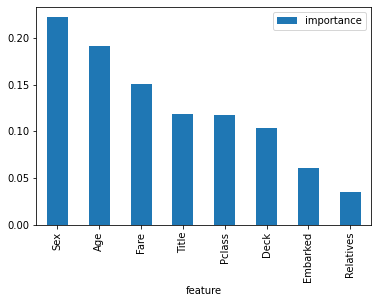

In [154]:
importancia.plot.bar()

### KNN

In [155]:
from sklearn.neighbors import KNeighborsClassifier

In [156]:
knn_titanic = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski', p = 2)
knn_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [157]:
previsoes_knn = knn_titanic.predict(X_titanic_teste)
previsoes_knn

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [158]:
knn_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_knn = round(knn_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_knn

84.7

### Regressão Logística

In [159]:
from sklearn.linear_model import LogisticRegression

In [160]:
logistic_titanic = LogisticRegression()
logistic_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [161]:
previsoes_logistic = logistic_titanic.predict(X_titanic_teste)
previsoes_logistic

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [162]:
logistic_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_logistic = round(logistic_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_logistic

79.19

### Vetores de Suporte

In [163]:
from sklearn.svm import SVC

In [164]:
svm_titanic = SVC(kernel = 'linear', C = 1.0)
svm_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [165]:
previsoes_svm = svm_titanic.predict(X_titanic_teste)
previsoes_svm

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [166]:
svm_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_svm = round(svm_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_svm

78.63

### Xgboost

In [167]:
!pip install xgboost

In [168]:
from xgboost import XGBClassifier

In [169]:
xgboost_titanic = XGBClassifier()
xgboost_titanic.fit(X_titanic_treinamento, y_titanic_treinamento)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [170]:
previsoes_xgboost = xgboost_titanic.predict(X_titanic_teste)
previsoes_xgboost

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [171]:
xgboost_titanic.score(X_titanic_treinamento, y_titanic_treinamento)
acc_xgboost = round(xgboost_titanic.score(X_titanic_treinamento, y_titanic_treinamento)*100, 2)
acc_xgboost

86.05

### Resumo dos resultados

In [172]:
resultados = pd.DataFrame({
    'Model': ['Naive Bayes','Decision Tree','Random Forest',
              'KNN', 'Logistic Regression','Support Vector Machines',
              'XGBoost'],
    'Score': [acc_naive, acc_arvore, acc_random_forest, 
              acc_knn, acc_logistic, acc_svm, acc_xgboost]})
resultados_df = resultados.sort_values(by='Score', ascending=False)
resultados_df = resultados_df.set_index('Score')
resultados_df.head(9)

,Model
Score,
90.44,Decision Tree
90.44,Random Forest
86.05,XGBoost
84.70,KNN
79.19,Logistic Regression
78.63,Support Vector Machines
74.80,Naive Bayes
